# Machine Learning

# PIPELINE

## Library

In [1]:
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Dataset

### DRIVE MOUNTING AND PATH DEFINITION

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the  dataset
original_dataset_dir = '/content/drive/MyDrive/PRO'  
#  path for splited dataset
split_dataset_dir = '/content/drive/MyDrive/ASL'  

train_dir = os.path.join(split_dataset_dir, 'train')
validation_dir = os.path.join(split_dataset_dir, 'validation')
test_dir = os.path.join(split_dataset_dir, 'test')

print(f"Train directory: {train_dir}")
print(f"Validation directory: {validation_dir}")
print(f"Test directory: {test_dir}")

Train directory: /content/drive/MyDrive/ASL/train
Validation directory: /content/drive/MyDrive/ASL/validation
Test directory: /content/drive/MyDrive/ASL/test


### Reproducibility with Random Seed Initialization

In [ ]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Checking GPU availability
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

### DATASET SPLITTING

In [ ]:
# Function to split the dataset
def split_dataset(original_dir, split_dir, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    for subset in ['train', 'validation', 'test']:
        os.makedirs(os.path.join(split_dir, subset), exist_ok=True)

    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        files = os.listdir(class_dir)
        random.shuffle(files)
        total_files = len(files)

        #  split indices count
        train_end = int(total_files * train_ratio)
        validation_end = train_end + int(total_files * validation_ratio)

        train_files = files[:train_end]
        validation_files = files[train_end:validation_end]
        test_files = files[validation_end:]

        # moving of files to their directories
        for file in train_files:
            os.makedirs(os.path.join(split_dir, 'train', class_name), exist_ok=True)
            shutil.copy(os.path.join(class_dir, file), os.path.join(split_dir, 'train', class_name, file))
        for file in validation_files:
            os.makedirs(os.path.join(split_dir, 'validation', class_name), exist_ok=True)
            shutil.copy(os.path.join(class_dir, file), os.path.join(split_dir, 'validation', class_name, file))
        for file in test_files:
            os.makedirs(os.path.join(split_dir, 'test', class_name), exist_ok=True)
            shutil.copy(os.path.join(class_dir, file), os.path.join(split_dir, 'test', class_name, file))

# running the split the dataset funtion 
split_dataset(original_dataset_dir, split_dataset_dir)
print(f"Dataset split completed!")

Dataset split completed!


## MODEL 

### Model Build, Train & Test

In [ ]:
# Shape Defnition
input_shape = (256, 256)  
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA transformations and data augmentation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

validation_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Loading datasets
train_dataset = datasets.ImageFolder(os.path.join(split_dataset_dir, "train"), transform=train_transforms)
validation_dataset = datasets.ImageFolder(os.path.join(split_dataset_dir, "validation"), transform=validation_transforms)
test_dataset = datasets.ImageFolder(os.path.join(split_dataset_dir, "test"), transform=validation_transforms)

# forming DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#   CNN model Definiton
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*32*128, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

# Initialize the model
num_classes = len(train_dataset.classes)

model = CNNModel(num_classes).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.0,0.9), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Define the training function
def train_model_with_tqdm(model, train_loader, validation_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training Phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc="Training", leave=False) as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                
                pbar.update(1)

        train_accuracy = 100. * correct / total
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation Phase
        model.eval()
        validation_loss = 0
        correct = 0
        total = 0

        with tqdm(total=len(validation_loader), desc="Validation", leave=False) as pbar:
            with torch.no_grad():
                for images, labels in validation_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    
                    pbar.update(1)

        validation_accuracy = 100. * correct / total
        print(f"Validation Loss: {validation_loss / len(validation_loader):.4f}, Validation Accuracy: {validation_accuracy:.2f}%")


train_model_with_tqdm(model, train_loader, validation_loader, criterion, optimizer, epochs=20)

# Test function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100. * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy

# Evaluate the model
evaluate_model(model, test_loader)

Epoch 1/20


Train Loss: 2.8636, Train Accuracy: 6.52%


Validation Loss: 2.8677, Validation Accuracy: 6.24%
Epoch 2/20


Train Loss: 2.8654, Train Accuracy: 6.36%


Validation Loss: 2.8150, Validation Accuracy: 11.20%
Epoch 3/20


Train Loss: 2.7197, Train Accuracy: 20.82%


Validation Loss: 2.4430, Validation Accuracy: 49.08%
Epoch 4/20


Train Loss: 2.4394, Train Accuracy: 48.94%


Validation Loss: 2.3626, Validation Accuracy: 56.98%
Epoch 5/20


Train Loss: 2.3217, Train Accuracy: 60.78%


Validation Loss: 2.2278, Validation Accuracy: 70.81%
Epoch 6/20


Train Loss: 2.2318, Train Accuracy: 69.70%


Validation Loss: 2.2209, Validation Accuracy: 71.47%
Epoch 7/20


Train Loss: 2.2214, Train Accuracy: 70.87%


Validation Loss: 2.2211, Validation Accuracy: 71.47%
Epoch 8/20


Train Loss: 2.2201, Train Accuracy: 70.90%


Validation Loss: 2.2056, Validation Accuracy: 73.03%
Epoch 9/20


Train Loss: 2.2099, Train Accuracy: 71.89%


Validation Loss: 2.1487, Validation Accuracy: 78.93%
Epoch 10/20


Train Loss: 2.1082, Train Accuracy: 82.23%


Validation Loss: 2.0228, Validation Accuracy: 91.47%
Epoch 11/20


Train Loss: 2.0273, Train Accuracy: 90.39%


Validation Loss: 2.0206, Validation Accuracy: 91.72%
Epoch 12/20


Train Loss: 2.0260, Train Accuracy: 90.49%


Validation Loss: 2.0217, Validation Accuracy: 91.61%
Epoch 13/20


Train Loss: 2.0001, Train Accuracy: 93.06%


Validation Loss: 1.9588, Validation Accuracy: 98.13%
Epoch 14/20


Train Loss: 1.9640, Train Accuracy: 96.69%


Validation Loss: 1.9604, Validation Accuracy: 97.92%
Epoch 15/20


Train Loss: 1.9624, Train Accuracy: 96.84%


Validation Loss: 1.9614, Validation Accuracy: 97.75%
Epoch 16/20


Train Loss: 1.9624, Train Accuracy: 96.90%


Validation Loss: 2.1101, Validation Accuracy: 83.08%
Epoch 17/20


Train Loss: 1.9609, Train Accuracy: 96.91%


Validation Loss: 1.9627, Validation Accuracy: 97.54%
Epoch 18/20


Train Loss: 1.9611, Train Accuracy: 96.93%


Validation Loss: 1.9627, Validation Accuracy: 97.61%
Epoch 19/20


Train Loss: 1.9599, Train Accuracy: 97.05%


Validation Loss: 1.9553, Validation Accuracy: 98.34%
Epoch 20/20


Train Loss: 1.9589, Train Accuracy: 97.20%


Validation Loss: 1.9582, Validation Accuracy: 98.06%
Test Loss: 1.9707, Test Accuracy: 97.71%


(1.9706570428350698, 97.71468144044321)

### Model Summary

In [29]:
from torchsummary import summary

# Display the summary
summary(model, input_size=(1, 256, 256))  # (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Linear-13                 [-1, 1024]     134,218,752
             ReLU-14                 [-

### Saving The Model

In [30]:
# Save the entire model
torch.save(model, "CNN.pth")

# Load the entire model
loaded_model = torch.load("CNN.pth")
loaded_model.eval()

<ipython-input-30-f2ff125d6dfc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("CNN.pth")


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(

### Model Evaluation

In [ ]:
# Test function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100. * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy

# Evaluation
evaluate_model(loaded_model, test_loader)

Test Loss: 1.9707, Test Accuracy: 97.71%


(1.9706570428350698, 97.71468144044321)

### Accuracy Plots

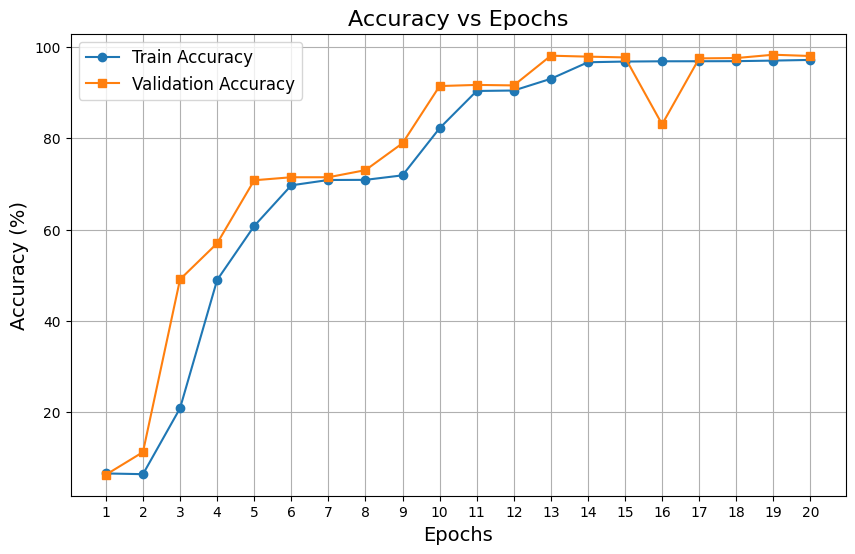

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21)) 
train_accuracy = [6.52, 6.36, 20.82, 48.94, 60.78, 69.70, 70.87, 70.90, 71.89, 82.23, 90.39, 90.49, 93.06, 96.69, 96.84, 96.90, 96.91, 96.93, 97.05, 97.20]
validation_accuracy = [6.24, 11.20, 49.08, 56.98, 70.81, 71.47, 71.47, 73.03, 78.93, 91.47, 91.72, 91.61, 98.13, 97.92, 97.75, 83.08, 97.54, 97.61, 98.34, 98.06]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='s')

# Adding labels, title, and legend
plt.title('Accuracy vs Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(epochs)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Confusion Matrix

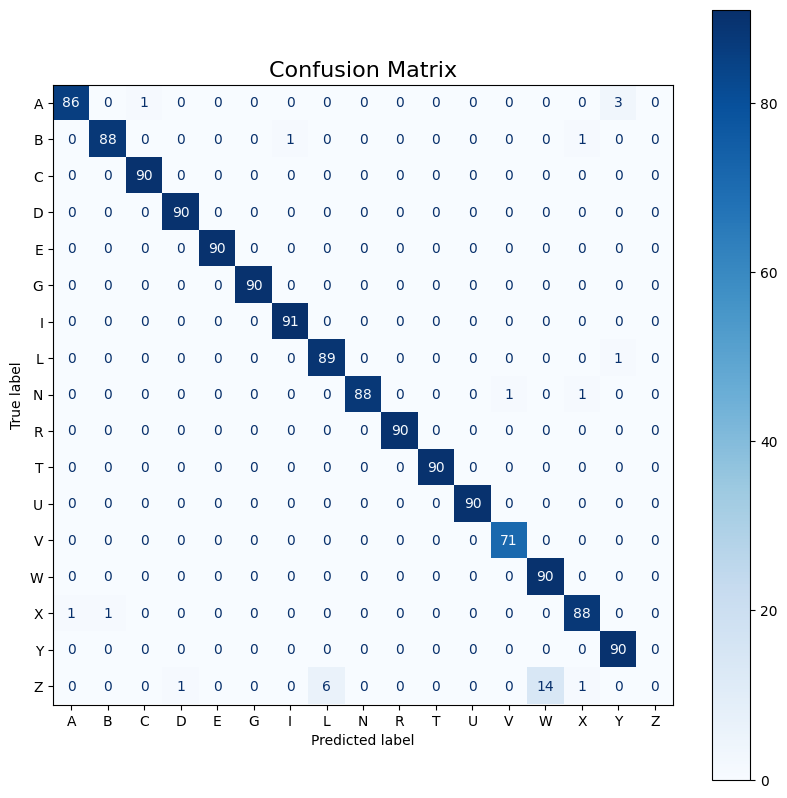

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute predictions and true labels
def compute_confusion_matrix(model, test_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():  # no gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #  confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='Blues', ax=ax, colorbar=True)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class_names = ['A', 'B', 'C', 'D', 'E',
               'G', 'I', 'L', 'N', 'R',
               'T', 'U', 'V', 'W', 'X',
               'Y', 'Z'] 

cm = compute_confusion_matrix(model, test_loader, device)
plot_confusion_matrix(cm, class_names)


### Implementation

## implemenatation Funtion

In [1]:
import cv2
import rembg
from PIL import Image
import numpy as np
import random

# Function to capture an image from the default camera, remove the background, and preprocess it
def capture_and_preprocess():
    # Open the default camera (camera index 0)
    cap = cv2.VideoCapture(0)

    # Allow the camera to adjust (you may need to adjust the delay based on your camera)
    cv2.waitKey(1000)

    # Read a frame from the camera
    ret, frame = cap.read()

    # Release the camera capture
    cap.release()

    if ret:
        # Convert the OpenCV frame to a PIL Image
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Use rembg to remove the background
        result = rembg.remove(pil_image)
        sign = cv2.cvtColor(np.array(result), cv2.COLOR_RGBA2GRAY)

        # Resize the image to the target size (256x256)
        target_size = (256, 256)
        resized_image = cv2.resize(sign, target_size)

        # Denoise the image (optional)
        denoised_image = cv2.fastNlMeansDenoising(resized_image, None, 30, 7, 21)

        return frame, denoised_image
    else:
        print("Failed to capture an image.")
        return None, None


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### USER INPUT TEST

In [ ]:
# Capture an image, remove the background, and preprocess it
input_image, preprocessed_image = capture_and_preprocess()

# Check if the preprocessed image was successfully captured
if preprocessed_image is not None:
    # Display the input image
    display(IPImage(data=cv2.imencode('.png', input_image)[1].tobytes(), format='png'))

    # Display the preprocessed image
    display(IPImage(data=cv2.imencode('.png', preprocessed_image)[1].tobytes(), format='png'))

    print("Image captured, background removed, and preprocessed.")
else:
    print("Image capture failed.")


# Assuming 'preprocessed_image' is your preprocessed image
input_array = np.expand_dims(preprocessed_image, axis=0)

# Make predictions on the input image
predictions = cnn_model.predict(input_array)



# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Find the class label with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_probability = predictions[0, predicted_class_index]

# Print the predicted class label and its probability
print(f"Predicted Class - {predicted_class_label}, Probability - {predicted_probability:.4f}")


print(predicted_class_label)

text_input = predicted_class_label
audio_output = text_to_speech(text_input)

audio_output